## Predspracovanie dat

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Definovanie vlastného datasetu, ktorý dedí z triedy Dataset
class IrisDataset(Dataset):
    def __init__(self, X_features, y_labels):
        # Inicializácia datasetu s featuremi a labelmi
        self.X_features = X_features
        self.y_labels = y_labels
    
    def __len__(self):
        # Návrat počtu záznamov v datasete
        return len(self.y_labels)
    
    def __getitem__(self, idx):
        # Návrat konkrétneho záznamu (features a labels) na základe indexu
        return self.X_features[idx], self.y_labels[idx]

# Načítanie dát z CSV súboru do DataFrame
csv_file = "dataset/iris.csv"
df = pd.read_csv(csv_file)

# Rozdelenie dát na features (X) a labels (y)
X = df.drop("species", axis=1).values  # Všetky stĺpce okrem 'species' sú features
y = df["species"].values  # 'species' stĺpec sú labels

# Transformácia textových labels na číselné hodnoty pomocou LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Rozdelenie dát na trénovaciu a testovaciu množinu, 80% tréning, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizácia dát na štandardnú škálu (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit a transformácia trénovacích dát
X_test_scaled = scaler.transform(X_test)  # Transformácia testovacích dát (bez fit)

# Konverzia normalizovaných dát do PyTorch tensorov
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# Vytvorenie vlastných datasetov pre tréning a testovanie z tensorov
train_dataset = IrisDataset(X_train_tensor, y_train_tensor)
test_dataset = IrisDataset(X_test_tensor, y_test_tensor)

# Vytvorenie DataLoaderov, ktoré budú podávať dáta po dávkach (batch_size)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Shuffle pre tréning
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # Bez shuffle pre test

# Vysvetlenie:
# Importy: Načítajú sa potrebné knižnice pre prácu s dátami, neuronovými sieťami, vizualizáciami a škálovaním dát.
# Dataset: Vytvára vlastnú triedu IrisDataset, ktorá bude spravovať dáta pre použitie s PyTorch.
# Načítanie dát: Načíta sa dataset z CSV súboru a rozdelí sa na vstupy (features) a výstupy (labels).
# Transformácia labels: Používa sa LabelEncoder, aby sa textové triedy premenili na číselné hodnoty.
# Rozdelenie dát: Dáta sa rozdelia na tréningovú a testovaciu množinu.
# Normalizácia dát: Features sa normalizujú na štandardnú škálu pomocou StandardScaler.
# Konverzia na tenzory: Normalizované dáta sa konvertujú na PyTorch tensory, aby boli pripravené na tréning s modelom.
# Vytvorenie datasetov: Vytvoria sa datasety pre tréning a testovanie, ktoré sa následne použijú na vytvorenie DataLoaderov.
# DataLoaders: DataLoaders poskytujú dávky dát pre tréning a testovanie modelu.

## KONTROLA

In [30]:
# print(X_train_tensor.shape, X_test_tensor.shape)
# print(y_train_tensor.shape, y_test_tensor.shape)

# print(f"Počet trénovacích vzoriek: {len(train_dataset)}")  # Vypíše počet vzoriek v tréningovom datasete
# print(f"Počet testovaných vzoriek: {len(test_dataset)}")  # Vypíše počet vzoriek vo validačnom datasete

# for features, labels in train_loader:
#     print(f"Features: {features.shape}")
#     print(f"Labels: {labels.shape}")

## Neuronova siet

In [31]:
# Definícia neuronovej siete pre klasifikáciu Iris datasetu
class IrisNetwork(nn.Module):
    def __init__(self):
        # Volanie konštruktora triedy nn.Module
        super(IrisNetwork, self).__init__()
        
        # Definícia prvej plne prepojenej vrstvy, ktorá má 4 vstupy (4 features) a 128 neurónov
        self.fc1 = nn.Linear(4, 128)
        
        # Definícia druhej plne prepojenej vrstvy s 128 vstupmi a 64 neurónmi
        self.fc2 = nn.Linear(128, 64)
        
        # Definícia tretej plne prepojenej vrstvy so 64 vstupmi a 32 neurónmi
        self.fc3 = nn.Linear(64, 32)
        
        # Definícia štvrtej plne prepojenej vrstvy s 32 vstupmi a 3 výstupmi (pre 3 triedy Iris)
        self.fc4 = nn.Linear(32, 3)
    
    def forward(self, x):
        # Priechod dát neuronovou sieťou, pričom na každej vrstve sa aplikuje ReLU aktivácia
        x = torch.relu(self.fc1(x))  # Aplikácia ReLU na výstup prvej vrstvy
        x = torch.relu(self.fc2(x))  # Aplikácia ReLU na výstup druhej vrstvy
        x = torch.relu(self.fc3(x))  # Aplikácia ReLU na výstup tretej vrstvy
        x = self.fc4(x)  # Výstup zo štvrtej vrstvy (bez aktivácie, pretože CrossEntropyLoss zahŕňa softmax)
        return x

# Inicializácia modelu neuronovej siete
model = IrisNetwork()

# Definícia loss funkcie pre klasifikáciu - CrossEntropyLoss sa používa pri viackategóriovej klasifikácii
criterion = nn.CrossEntropyLoss()

# Definícia optimalizátora - Adam optimalizátor, ktorý aktualizuje váhy modelu
# lr (learning rate) určuje rýchlosť učenia
# weight_decay pridáva regularizáciu na predchádzanie overfittingu
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Vysvetlenie:
# Neuronová sieť (IrisNetwork): Definovaná je sieť, ktorá obsahuje štyri plne prepojené vrstvy. Prvé tri vrstvy používajú ReLU ako aktivačnú funkciu. Posledná vrstva má tri neuróny, ktoré predstavujú tri triedy v Iris datasete (setosa, versicolor, virginica).
# Loss funkcia (criterion): Používa sa CrossEntropyLoss, ktorá je vhodná pre klasifikáciu, pretože kombinuje LogSoftmax a NLLLoss v jednej triede.
# Optimalizátor (optimizer): Adam optimalizátor sa používa na aktualizáciu váh modelu počas tréningu. lr=0.001 nastavuje rýchlosť učenia a weight_decay=0.01 pridáva regularizáciu na zníženie rizika overfittingu.

## Trenovanie modelu a Vizualizacia

Epoch [1/50], Train Loss: 0.7688, Test Loss: 0.3921, Test Accuracy: 91.43%
Epoch [2/50], Train Loss: 0.2091, Test Loss: 0.1117, Test Accuracy: 97.14%
Epoch [3/50], Train Loss: 0.0912, Test Loss: 0.0720, Test Accuracy: 97.62%
Epoch [4/50], Train Loss: 0.0747, Test Loss: 0.0640, Test Accuracy: 99.05%
Epoch [5/50], Train Loss: 0.0754, Test Loss: 0.0713, Test Accuracy: 96.67%
Epoch [6/50], Train Loss: 0.0681, Test Loss: 0.0591, Test Accuracy: 99.05%
Epoch [7/50], Train Loss: 0.0689, Test Loss: 0.0586, Test Accuracy: 98.57%
Epoch [8/50], Train Loss: 0.0620, Test Loss: 0.0577, Test Accuracy: 99.05%
Epoch [9/50], Train Loss: 0.0617, Test Loss: 0.0634, Test Accuracy: 98.57%
Epoch [10/50], Train Loss: 0.0627, Test Loss: 0.0696, Test Accuracy: 99.05%
Epoch [11/50], Train Loss: 0.0633, Test Loss: 0.0592, Test Accuracy: 97.62%
Epoch [12/50], Train Loss: 0.0612, Test Loss: 0.0560, Test Accuracy: 99.05%
Epoch [13/50], Train Loss: 0.0594, Test Loss: 0.0643, Test Accuracy: 98.57%
Epoch [14/50], Train 

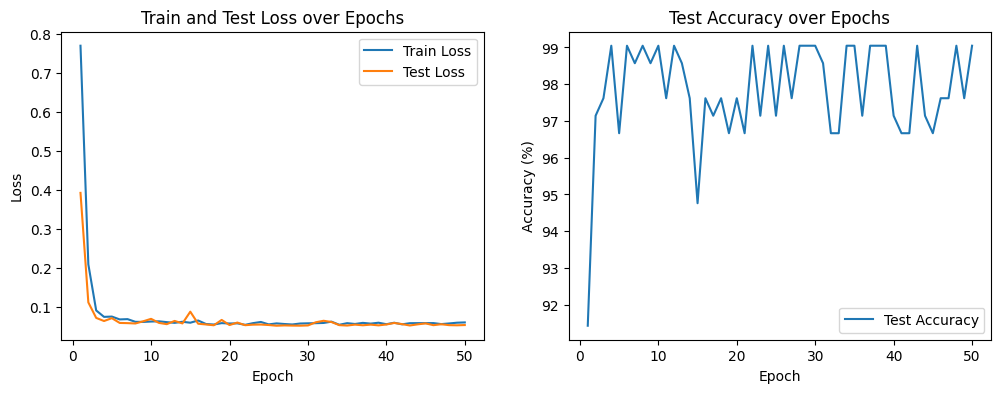

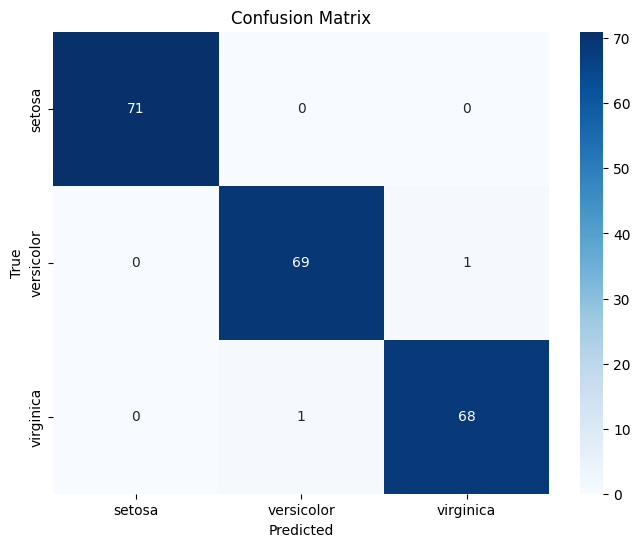

In [32]:
def train(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs):
    # Inicializácia zoznamov pre sledovanie stratovosti a presnosti
    train_losses = []
    test_losses = []
    test_accuracies = []
    
    # Hlavný tréningový cyklus pre počet epoch definovaný používateľom
    for epoch in range(num_epochs):
        model.train()  # Nastavenie modelu do tréningového režimu
        train_loss = 0.0  # Inicializácia stratovosti pre túto epochu
        
        # Cyklus prechádza všetky batche trénovacích dát
        for features, labels in train_dataloader:
            optimizer.zero_grad()  # Nulovanie gradientov pred každým krokom učenia
            outputs = model(features)  # Výpočet výstupu modelu pre aktuálny batch
            loss = criterion(outputs, labels)  # Výpočet stratovosti pre aktuálny batch
            loss.backward()  # Spätná propagácia chyby (výpočet gradientov)
            optimizer.step()  # Aktualizácia váh modelu na základe gradientov
            train_loss += loss.item()  # Akumulácia stratovosti pre túto epochu
            
        train_losses.append(train_loss / len(train_dataloader))  # Výpočet priemernej stratovosti pre túto epochu a uloženie
        
        model.eval()  # Nastavenie modelu do evaluačného režimu (vypnutie dropout, atď.)
        test_loss = 0.0  # Inicializácia stratovosti pre testovaciu množinu
        correct = 0  # Počet správnych predikcií
        total = 0  # Celkový počet vzoriek
        all_labels = []  # Zoznam všetkých skutočných hodnôt pre testovaciu množinu
        all_predictions = []  # Zoznam všetkých predikovaných hodnôt modelom

        # V rámci evaluačného režimu vypočítame presnosť na testovacej množine
        with torch.no_grad():  # Vypnutie výpočtu gradientov, urýchlenie evaluačného kroku
            for features, labels in test_dataloader:
                outputs = model(features)  # Predikcia modelu na testovacích dátach
                loss = criterion(outputs, labels)  # Výpočet stratovosti pre aktuálny batch testovacích dát
                test_loss += loss.item()  # Akumulácia stratovosti pre testovaciu množinu
                
                _, predicted = torch.max(outputs.data, 1)  # Výber triedy s najväčšou pravdepodobnosťou
                total += labels.size(0)  # Aktualizácia celkového počtu vzoriek
                correct += (predicted == labels).sum().item()  # Počet správnych predikcií

                all_labels.extend(labels.numpy())  # Pridanie aktuálnych hodnôt do zoznamu
                all_predictions.extend(predicted.numpy())  # Pridanie predikovaných hodnôt do zoznamu

        test_losses.append(test_loss / len(test_dataloader))  # Priemerná stratovosť na testovacej množine
        test_accuracy = 100 * correct / total  # Výpočet presnosti na testovacej množine
        test_accuracies.append(test_accuracy)  # Uloženie presnosti pre aktuálnu epochu
        
        # Vypísanie výsledkov pre aktuálnu epochu
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss/len(train_dataloader):.4f}, '
              f'Test Loss: {test_loss/len(test_dataloader):.4f}, '
              f'Test Accuracy: {test_accuracy:.2f}%')
    
    # Vizualizácia stratovosti (Loss) pre tréning a testovanie
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 4))
    
    # Vizualizácia tréningovej a testovacej stratovosti
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss over Epochs')
    plt.legend()

    # Vizualizácia presnosti na testovacej množine
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy over Epochs')
    plt.legend()
    plt.show()

    # Matica zámien (Confusion Matrix) pre testovaciu množinu
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC krivka (Receiver Operating Characteristic) pre binárnu klasifikáciu
    # Ak klasifikácia obsahuje dve triedy, zobrazi sa ROC krivka
    if len(le.classes_) == 2:
        all_labels_bin = label_binarize(all_labels, classes=[0, 1])  # Binarizácia skutočných hodnôt
        all_predictions_bin = label_binarize(all_predictions, classes=[0, 1])  # Binarizácia predikovaných hodnôt

        fpr, tpr, _ = roc_curve(all_labels_bin, all_predictions_bin)  # Výpočet falošných a pravých pozitív
        roc_auc = auc(fpr, tpr)  # Výpočet plochy pod krivkou (AUC)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

# Spustenie tréningu a vizualizácie s počtom epoch 50
train(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=50)

# Ako to funguje:
# Train and Test Loss: Vykresľuje stratovosť počas tréningu a testovania.
# Test Accuracy: Zobrazuje presnosť modelu na testovacej množine v každej epoch.
# Confusion Matrix: Vizualizuje, ako dobre model klasifikuje jednotlivé triedy.
# ROC Curve: Používa sa pre binárnu klasifikáciu na zobrazenie ROC krivky.

# Vysvetlenie:
# Tréning a Testovanie: Kód vykonáva tréning modelu na trénovacích dátach a testuje jeho výkon na testovacích dátach v každej epoche. V každej epoche sa počítajú stratovosť a presnosť.
# Vizualizácie: Po tréningu sa vykreslia grafy stratovosti pre tréning a testovanie, presnosť na testovacej množine, matica zámien a ROC krivka (ak je klasifikácia binárna).
# Konfúzna Matica a ROC Krivka: Pomocou matice zámien je možné vidieť, ktoré triedy sú správne alebo nesprávne klasifikované. ROC krivka sa používa na vyhodnotenie výkonu klasifikátora, najmä pre binárne klasifikácie.

## Uloženie Modelu

In [33]:
# Uloženie natrénovaného modelu
torch.save(model.state_dict(), 'iris_model.pth')

## Načítanie Uloženého Modelu

In [34]:
# Načítanie modelu s bezpečným nastavením
model = IrisNetwork()  # Inicializácia rovnakej štruktúry modelu
model.load_state_dict(torch.load('iris_model.pth', weights_only=True))
model.eval()  # Prepnutie modelu do evaluačného režimu

IrisNetwork(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
)

## Vyhodnotenie modelu na testovacích dátach

In [35]:
# Vyhodnotenie modelu na testovacích dátach
# model.eval()  # Prepnutie modelu do evaluačného režimu (už bolo nastavené vyššie v kóde)

correct = 0  # Inicializácia počítadla pre správne predikcie
total = 0    # Inicializácia počítadla pre celkový počet vzoriek

# Vypnutie výpočtu gradientov, keďže sa len vyhodnocuje model
with torch.no_grad():
    # Iterácia cez všetky batche testovacích dát
    for features, labels in test_dataloader:
        outputs = model(features)  # Predikcia modelu na základe testovacích dát
        _, predicted = torch.max(outputs.data, 1)  # Výber triedy s najväčšou pravdepodobnosťou
        total += labels.size(0)  # Aktualizácia celkového počtu vzoriek
        correct += (predicted == labels).sum().item()  # Počet správnych predikcií sa pripočíta

# Výpočet celkovej presnosti modelu na testovacích dátach
accuracy = 100 * correct / total
print(f'Test Accuracy of the model on the test data: {accuracy:.2f}%')

# Vysvetlenie:
# Prepnutie modelu do evaluačného režimu (model.eval()): Už bolo spomenuté vyššie v kóde, takže ho tu nie je potrebné opäť používať, ale je dobré si uvedomiť, že v evaluačnom režime sa deaktivujú určité vrstvy, ako je dropout, aby sa zabezpečilo konzistentné správanie počas testovania.

# Správne a celkové počítanie: Počítame správne predikované triedy a celkový počet vzoriek, aby sme mohli vypočítať presnosť modelu.

# Výpočet presnosti: Nakoniec sa vypočíta presnosť ako podiel správnych predikcií z celkového počtu vzoriek v testovacej množine. Výsledok sa zobrazí v percentách.

Test Accuracy of the model on the test data: 99.05%


## Generovanie predikcií na nových dátach

In [36]:
# Predpokladajme, že máš nové dáta v tvare [sepal_length, sepal_width, petal_length, petal_width]
new_data = np.array([[7.0, 3.2, 4.7, 1.4]])  # Príklad nových dát vo forme numpy array

# Normalizácia nových dát, ak si použil scaler na trénovacie dáta
new_data = scaler.transform(new_data)  # Použitie scaler.transform na normalizáciu
new_data = torch.FloatTensor(new_data)  # Prevod na tensor

# Predikcia pomocou modelu
model.eval()  # Nastavenie modelu do evaluačného režimu
with torch.no_grad():  # Deaktivácia výpočtu gradientov
    output = model(new_data)  # Predikcia modelu na nových dátach
    _, predicted = torch.max(output.data, 1)  # Získanie indexu triedy s najvyššou pravdepodobnosťou
    print(f'Predikovaný druh: {le.inverse_transform(predicted.numpy())}')  # Vykonanie spätného prevodu predikcie na pôvodné triedy

# Vysvetlenie:
# new_data:
# np.array([[7.0, 3.2, 4.7, 1.4]]): Nové dáta sú vytvorené ako numpy array. Pre konverziu z numpy array na tensor je dôležité zabezpečiť, aby boli dáta správne normalizované pred ich použitím.

# Normalizácia nových dát:
# scaler.transform(new_data): Použitie rovnakého scaler (t.j. StandardScaler), ktorý bol použitý na trénovanie modelu. To zabezpečí, že nové dáta budú mať rovnaké škálovanie ako trénovacie dáta.
# torch.FloatTensor(new_data): Konverzia normalizovaných dát na tensor, ktorý môžeme použiť v PyTorch.

# Predikcia:
# model.eval(): Prepne model do evaluačného režimu, čo deaktivuje dropout a iné vrstvy, ktoré sa správajú inak počas tréningu.
# with torch.no_grad(): Vypne výpočty gradientov, čo je efektívne pri evaluácii a predikcii.
# output = model(new_data): Vykoná predikciu pre nové dáta.
# torch.max(output.data, 1): Získa index triedy s najvyššou pravdepodobnosťou.
# le.inverse_transform(predicted.numpy()): Premení predikované indexy na pôvodné názvy tried pomocou LabelEncoder.

Predikovaný druh: ['versicolor']


## Ukladanie predikcií do CSV súboru

In [37]:
# Predpokladajme, že máš testovacie dáta už spracované
predictions = []  # Inicializácia zoznamu na uchovávanie predikovaných štítkov
true_labels = []  # Inicializácia zoznamu na uchovávanie skutočných štítkov

model.eval()  # Nastavenie modelu do evaluačného režimu (deaktivácia dropout vrstiev a iných špecifických tréningových funkcií)
with torch.no_grad():  # Deaktivácia výpočtu gradientov počas evaluácie
    for features, labels in test_dataloader:  # Iterácia cez testovacie dáta
        outputs = model(features)  # Predikcia modelu na aktuálnych testovacích dátach
        _, predicted = torch.max(outputs.data, 1)  # Získanie indexu triedy s najvyššou pravdepodobnosťou
        predictions.extend(predicted.numpy())  # Pridanie predikovaných štítkov do zoznamu
        true_labels.extend(labels.numpy())  # Pridanie skutočných štítkov do zoznamu

# Vytvor DataFrame a ulož do CSV
df = pd.DataFrame({'True Label': true_labels, 'Predicted Label': predictions})  # Vytvorenie DataFrame s dvoma stĺpcami: True Label a Predicted Label
df.to_csv('predictions.csv', index=False)  # Uloženie DataFrame do CSV súboru bez indexov

# Vysvetlenie:
# Inicializácia zoznamov:
# predictions a true_labels sú prázdne zoznamy, do ktorých sa neskôr pridajú predikované a skutočné štítky.

# Nastavenie modelu na evaluáciu:
# model.eval(): Prepne model do režimu evaluácie. Tento krok je dôležitý, aby model správne fungoval počas evaluácie (napríklad vypne dropout).

# Deaktivácia výpočtu gradientov:
# with torch.no_grad(): Zabezpečuje, že gradienty sa nebudú počítať, čo šetrí pamäť a zrychľuje výpočty pri evaluácii a predikcii.

# Iterácia cez testovacie dáta:
# for features, labels in test_dataloader: Prechádza každú dávku testovacích dát.

# Predikcia a ukladanie výsledkov:
# outputs = model(features): Vykoná predikciu na aktuálnych dáta.
# _, predicted = torch.max(outputs.data, 1): Určí index najvyššej pravdepodobnosti (predikovaná trieda).
# predictions.extend(predicted.numpy()): Pridá predikované štítky do zoznamu.
# true_labels.extend(labels.numpy()): Pridá skutočné štítky do zoznamu.

# Vytvorenie a uloženie DataFrame:
# df = pd.DataFrame({'True Label': true_labels, 'Predicted Label': predictions}): Vytvorí DataFrame s dvoma stĺpcami: "True Label" a "Predicted Label".
# df.to_csv('predictions.csv', index=False): Uloží DataFrame do CSV súboru bez indexov.

## Načítanie uložených predikcií

In [38]:
# Načítanie predikcií z CSV
df = pd.read_csv('predictions.csv')
print(df.head())

   True Label  Predicted Label
0           1                1
1           1                1
2           0                0
3           1                1
4           0                0
